In [98]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [100]:
# Aggregate transaction data to get customer-level insights
customer_transactions = transactions_df.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "TransactionID": "count"  # Number of transactions
}).reset_index()


In [101]:
# Merge customer profile data with aggregated transaction data
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="inner")
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,TransactionID
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12,5
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10,4
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14,4
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23,8
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7,3


In [102]:
# Select features for clustering
features = ["Region", "TotalValue", "Quantity", "TransactionID"]
categorical_features = ["Region"]
numerical_features = ["TotalValue", "Quantity", "TransactionID"]

In [103]:
# One-hot encode categorical features
customer_data_encoded = pd.get_dummies(customer_data, columns=categorical_features, drop_first=True, dtype='int')

In [104]:
# Standardize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data_encoded[numerical_features])
customer_data_encoded[numerical_features] = scaled_features

In [105]:
customer_data_encoded.head()

,CustomerID,CustomerName,SignupDate,TotalValue,Quantity,TransactionID,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,2022-07-10,-0.061701,-0.122033,-0.011458,0,0,1
1,C0002,Elizabeth Lutz,2022-02-13,-0.877744,-0.448000,-0.467494,0,0,0
2,C0003,Michael Rivera,2024-03-07,-0.405857,0.203934,-0.467494,0,0,1
3,C0004,Kathleen Rodriguez,2022-10-09,1.032547,1.670787,1.356650,0,0,1
4,C0005,Laura Weber,2022-08-15,-0.783929,-0.936951,-0.923530,0,0,0


In [106]:
# Initialize PCA for visualization
pca = PCA(n_components=2)

# Store results for comparison
db_scores = {}
silhouette_scores = {}

Text(0.5, 0.98, 'KMeans Clustering Results')

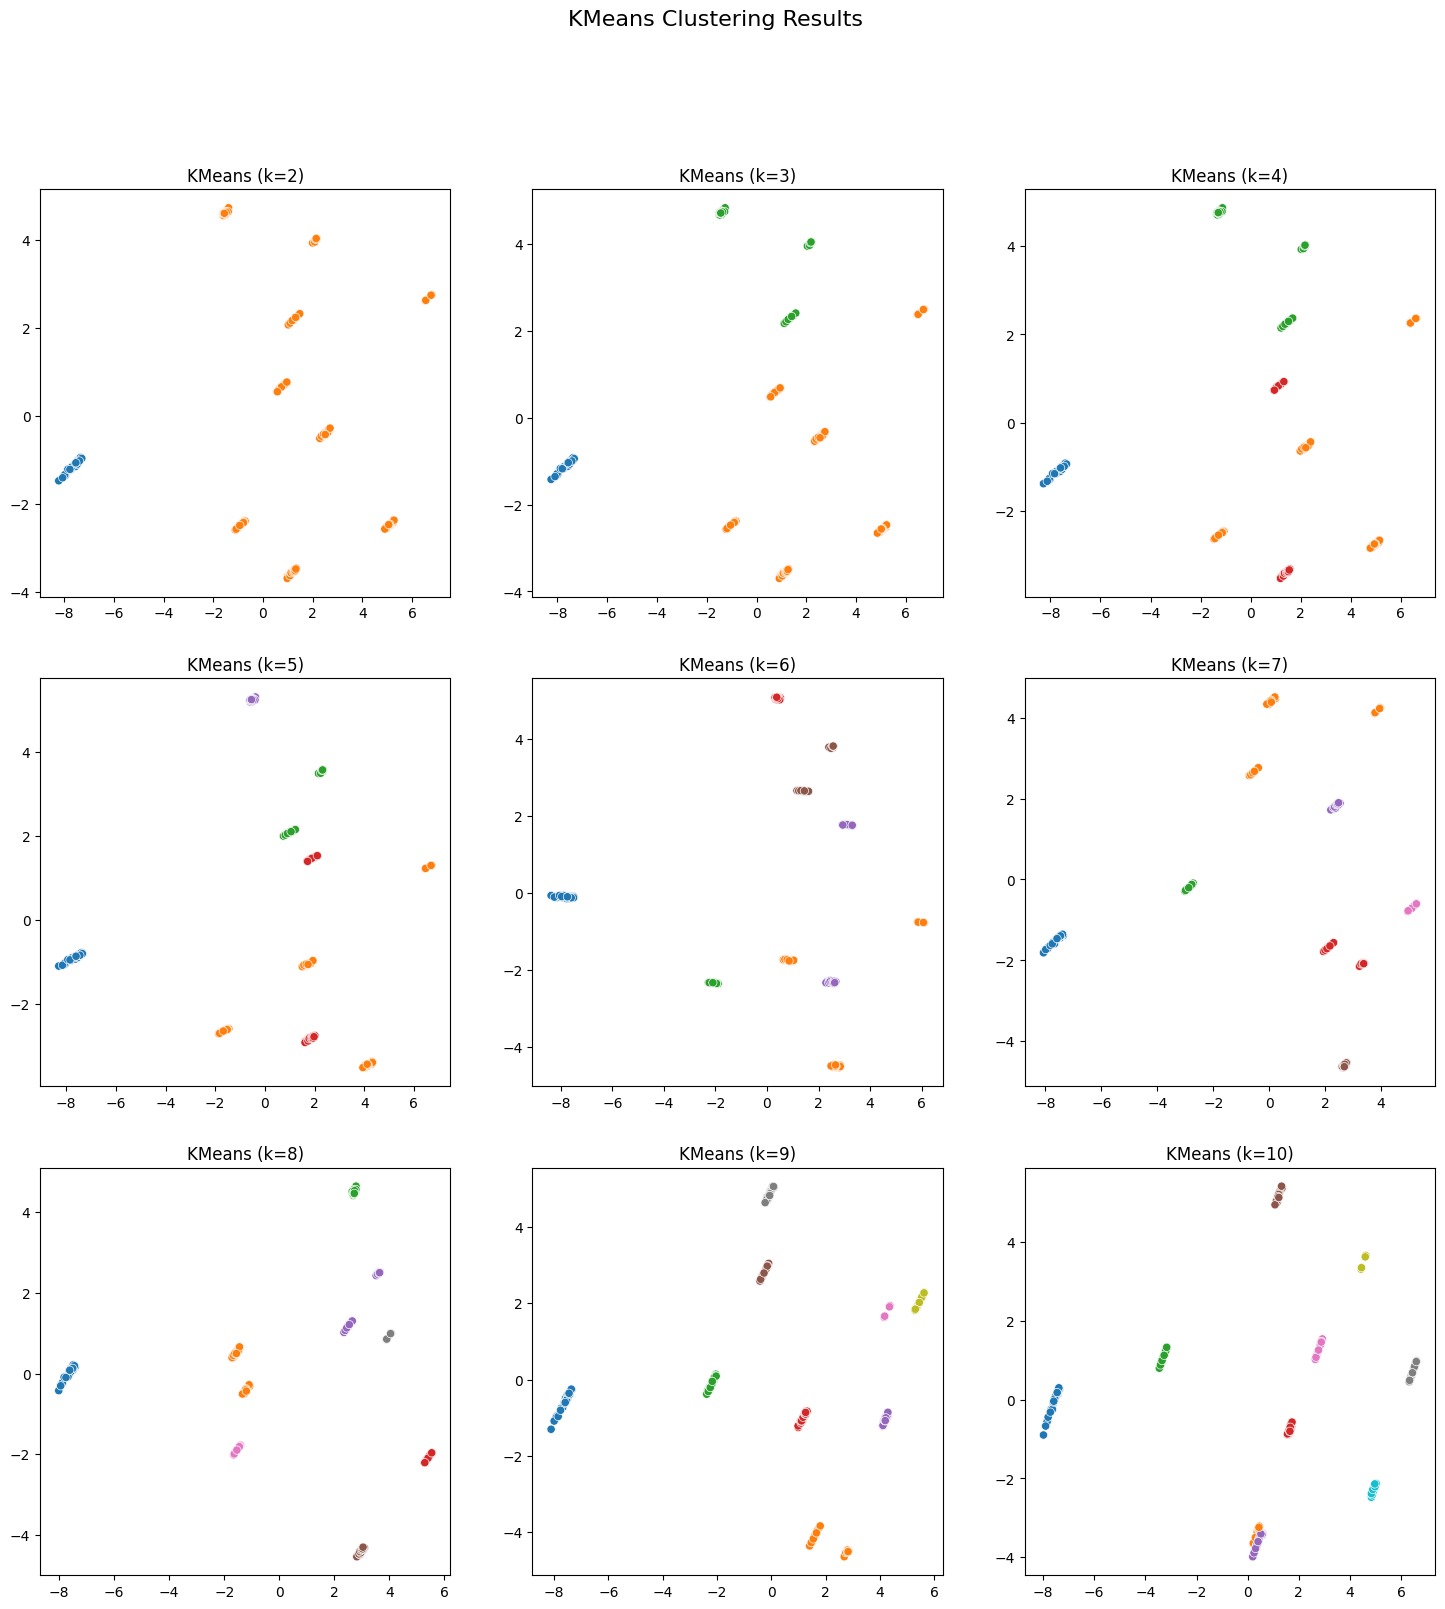

In [111]:
# KMeans clustering with k=2 to k=10
fig_kmeans, axes_kmeans = plt.subplots(3, 3, figsize=(18, 18))
kmeans_db_scores = []
kmeans_silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_data_encoded[f'Cluster_KMeans_{k}'] = kmeans.fit_predict(customer_data_encoded.select_dtypes(exclude='object'))
    db_index = davies_bouldin_score(customer_data_encoded.select_dtypes(exclude='object'), 
                                    customer_data_encoded[f'Cluster_KMeans_{k}'])
    silhouette_avg = silhouette_score(customer_data_encoded.select_dtypes(exclude='object'), 
                                       customer_data_encoded[f'Cluster_KMeans_{k}'])
    kmeans_db_scores.append(db_index)
    kmeans_silhouette_scores.append(silhouette_avg)

    # Visualize clusters
    pca_components = pca.fit_transform(customer_data_encoded.select_dtypes(exclude='object'))
    row, col = divmod(k-2, 3)
    ax = axes_kmeans[row, col]
    sns.scatterplot(
        x=pca_components[:, 0],
        y=pca_components[:, 1],
        hue=customer_data_encoded[f'Cluster_KMeans_{k}'],
        palette='tab10',
        ax=ax,
        legend=None
    )
    ax.set_title(f"KMeans (k={k})")

fig_kmeans.suptitle("KMeans Clustering Results", fontsize=16)

In [112]:
# Save KMeans scores
db_scores['KMeans'] = kmeans_db_scores
silhouette_scores['KMeans'] = kmeans_silhouette_scores

Text(0.5, 0.98, 'Hierarchical Clustering Results')

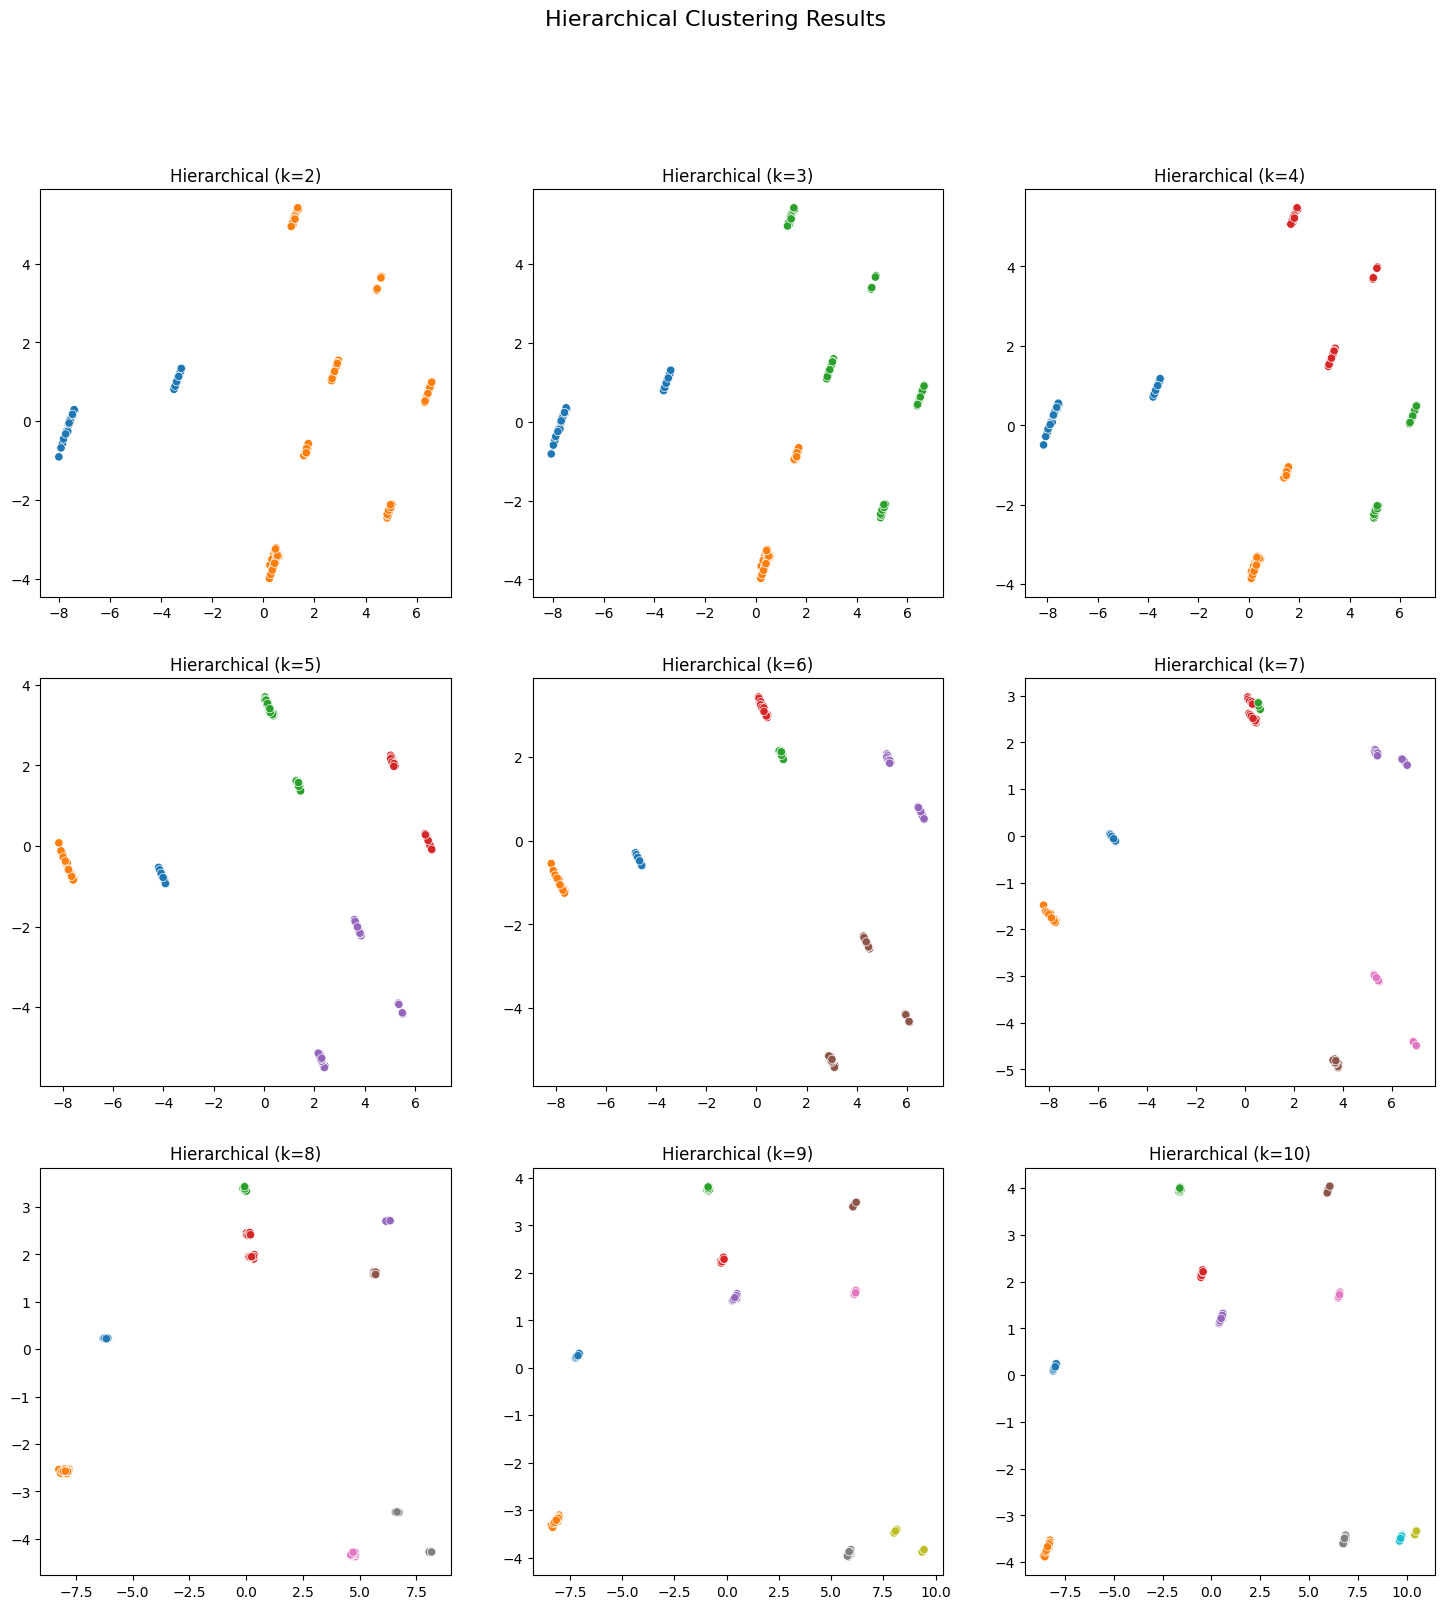

In [113]:
# Hierarchical clustering with clusters from 2 to 10
fig_hierarchical, axes_hierarchical = plt.subplots(3, 3, figsize=(18, 18))
hierarchical_db_scores = []
hierarchical_silhouette_scores = []
hierarchical_model = linkage(customer_data_encoded.select_dtypes(exclude='object'), method='ward')
for k in range(2, 11):
    hierarchical_clusters = fcluster(hierarchical_model, t=k, criterion='maxclust')
    customer_data_encoded[f'Cluster_Hierarchical_{k}'] = hierarchical_clusters
    db_index = davies_bouldin_score(customer_data_encoded.select_dtypes(exclude='object'), hierarchical_clusters)
    silhouette_avg = silhouette_score(customer_data_encoded.select_dtypes(exclude='object'), hierarchical_clusters)
    hierarchical_db_scores.append(db_index)
    hierarchical_silhouette_scores.append(silhouette_avg)

    # Visualize clusters
    pca_components = pca.fit_transform(customer_data_encoded.select_dtypes(exclude='object'))
    row, col = divmod(k-2, 3)
    ax = axes_hierarchical[row, col]
    sns.scatterplot(
        x=pca_components[:, 0],
        y=pca_components[:, 1],
        hue=hierarchical_clusters,
        palette='tab10',
        ax=ax,
        legend=None
    )
    ax.set_title(f"Hierarchical (k={k})")

fig_hierarchical.suptitle("Hierarchical Clustering Results", fontsize=16)

In [114]:
# Save Hierarchical scores
db_scores['Hierarchical'] = hierarchical_db_scores
silhouette_scores['Hierarchical'] = hierarchical_silhouette_scores

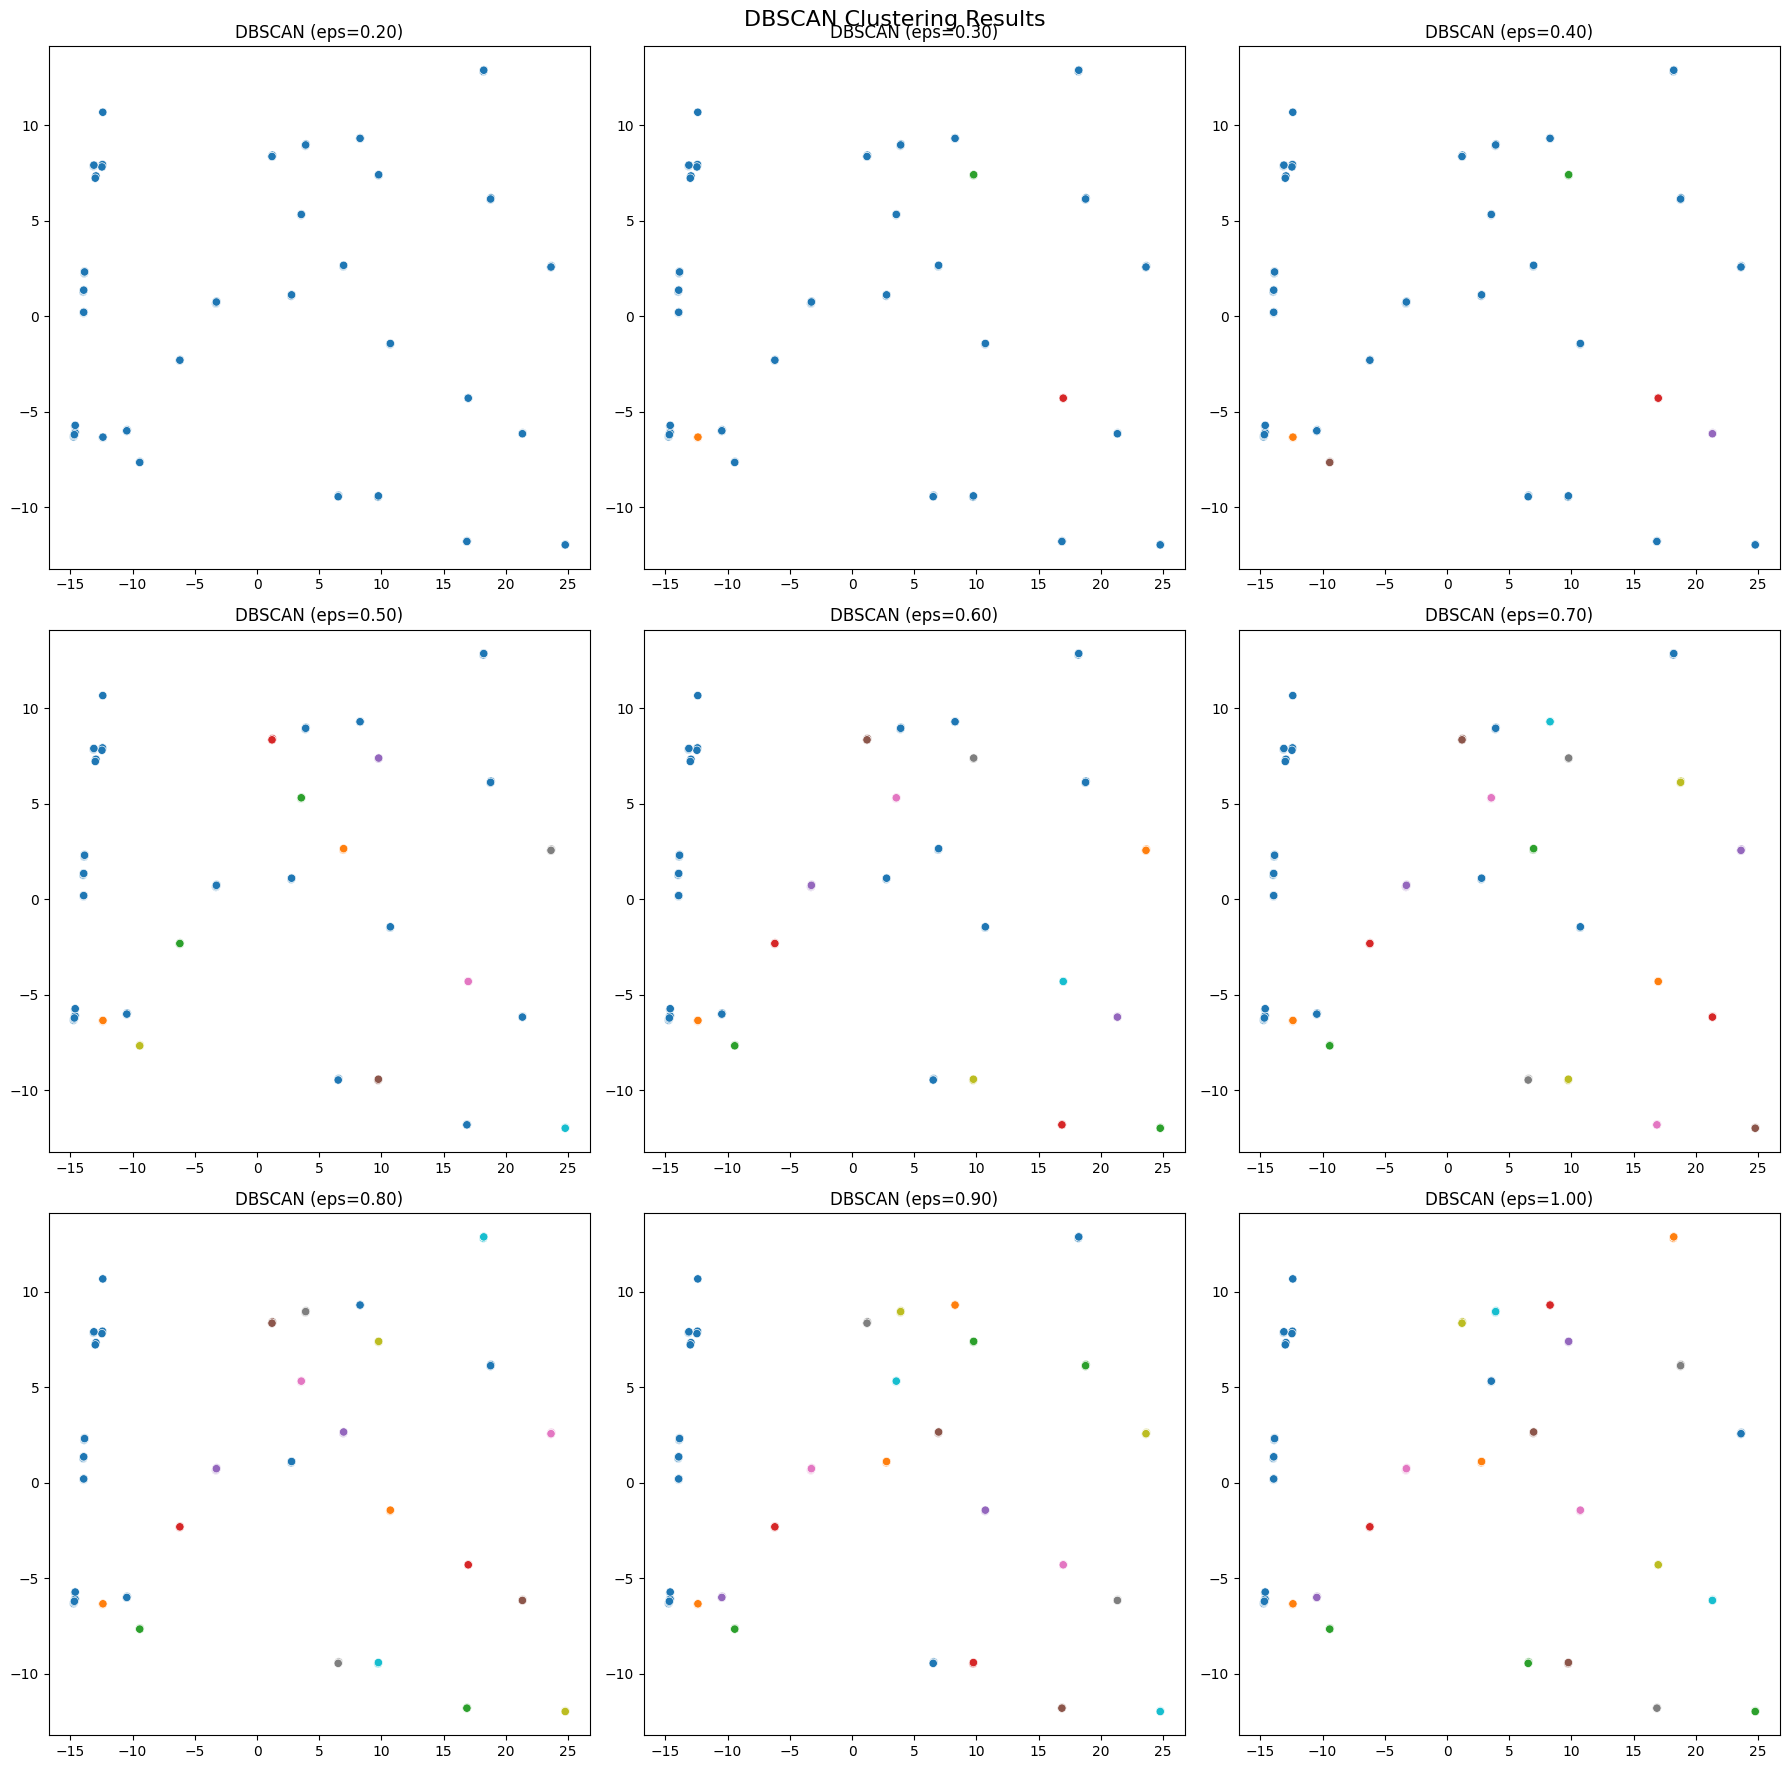

In [123]:
# DBSCAN clustering with varying eps values to simulate clusters from 2 to 10
fig_dbscan, axes_dbscan = plt.subplots(3, 3, figsize=(18, 18))
dbscan_db_index = []
dbscan_silhouette = []
for k in range(2, 11):
    eps = 0.1 * k  # Adjust eps dynamically
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_clusters = dbscan.fit_predict(customer_data_encoded.select_dtypes(exclude='object'))
    customer_data_encoded[f'Cluster_DBSCAN_{k}'] = dbscan_clusters


    # Calculate DB and Silhouette scores (only if there are >1 clusters)
    if len(set(dbscan_clusters)) > 1:
        db_index = davies_bouldin_score(customer_data_encoded.select_dtypes(exclude='object'), dbscan_clusters)
        dbscan_db_index.append(db_index)
        silhouette_avg = silhouette_score(customer_data_encoded.select_dtypes(exclude='object'), dbscan_clusters)
        dbscan_silhouette.append(silhouette_avg)
    else:
        db_index = float('inf')  # Not meaningful if only 1 cluster
        silhouette_avg = float('nan')

    # Visualize clusters
    pca_components = pca.fit_transform(customer_data_encoded.select_dtypes(exclude='object'))
    row, col = divmod(k-2, 3)
    ax = axes_dbscan[row, col]
    sns.scatterplot(
        x=pca_components[:, 0],
        y=pca_components[:, 1],
        hue=dbscan_clusters,
        palette='tab10',
        ax=ax,
        legend=None
    )
    ax.set_title(f"DBSCAN (eps={eps:.2f})")

fig_dbscan.suptitle("DBSCAN Clustering Results", fontsize=16)

plt.tight_layout()
plt.show()

In [126]:
# Report clustering results
print("Clustering Results:")
print("KMeans DB Index for k=2 to k=10:", kmeans_db_scores)
print("KMeans Silhouette Scores for k=2 to k=10:", kmeans_silhouette_scores)
print("Hierarchical Clustering DB Index:", hierarchical_db_scores)
print("Hierarchical Clustering Silhouette Scores:", hierarchical_silhouette_scores)
print("DBSCAN DB Index:", dbscan_db_index)
print("DBSCAN Silhouette Scores:", dbscan_silhouette)

Clustering Results:
KMeans DB Index for k=2 to k=10: [0.6396356534592601, 1.0255236877826357, 0.9357269587285129, 0.7903241987323855, 0.6210420080354814, 0.4297506406206444, 0.3565793955026284, 0.32230585095550945, 0.3183038771520768]
KMeans Silhouette Scores for k=2 to k=10: [0.43689066563560597, 0.4127586436121618, 0.49354361777185884, 0.5373496584226373, 0.6188221841335473, 0.6931944987972317, 0.7585014010013479, 0.7794316574989436, 0.774650188573219]
Hierarchical Clustering DB Index: [0.9228929767758832, 1.1478262113551971, 0.9790698776363663, 0.8309571897828943, 0.6945520494796004, 0.5690848155905632, 0.407235788977782, 0.3360759123821357, 0.28871027976574565]
Hierarchical Clustering Silhouette Scores: [0.4193999070543145, 0.4382197035836984, 0.5185709081759197, 0.5580906350114329, 0.6140566688875273, 0.6771514924848628, 0.7408527386554978, 0.7749911276704176, 0.7907169752687191]
DBSCAN DB Index: [1.0757686899176244, 0.9911275524685266, 0.9325878876826432, 1.054978361532967, 0.710